# Hypothesis Testing

## AI Usage Disclosure

A large language model (LLM) was used **only to improve the visual quality and clarity of plots** in the hypothesis testing sections of this project.

Specifically, the LLM contributed to:
- minor enhancements to plotting structure  
- suggestions for label formatting and axis readability  
- optional improvements such as adding reference lines or adjusting opacity  

Any visualization-related code segments directly suggested or refined by the LLM are **explicitly marked with comments** inside the scripts.

The LLM did **not** generate the dataset, perform the statistical analysis, compute results, decide hypotheses, or influence any interpretations or conclusions.  
All analytical decisions—including data cleaning, transformations, feature definitions, hypothesis formulation, statistical testing, and interpretation—were made entirely by me.

The LLM’s role was strictly limited to **non-analytical aesthetic improvements** for better presentation and readability.


### 0. Load Cleaned Dataset

This dataset contains merged financial, rating, and award information from Box Office Mojo, OMDb API, and my personal IMDb ratings export. It is fully cleaned and ready for statistical testing.

In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 180)

DATA_DIR = "/content/drive/MyDrive/DSA PROJE DATA/OMDB/"
CLEAN_PATH = os.path.join(DATA_DIR, "movies_clean.csv")

movies_df = pd.read_csv(CLEAN_PATH)

print("Loaded dataset with shape:", movies_df.shape)
movies_df.head()

Loaded dataset with shape: (3173, 39)


,movie_id,Title,Year,trivia,mpaa,release_date,run_time,distributor,director,writer,producer,composer,cinematographer,main_actor_1,main_actor_2,main_actor_3,main_actor_4,budget,domestic,international,worldwide,genre_1,genre_2,genre_3,genre_4,html,imdb_id,awards_text,omdb_boxoffice,omdb_imdb_rating,omdb_metascore,omdb_imdb_votes,response_ok,error_msg,fetched_at,omdb_boxoffice_usd,oscar_winner_flag,oscar_nominee_flag,MyRating
0,tt0099088,Back to the Future Part III,1990,"Stranded in 1955, Marty McFly learns about the...",NaN,May 25,1 hr 58 min,Universal Pictures,Robert Zemeckis,Robert Zemeckis,Neil Canton,Alan Silvestri,Dean Cundey,Michael J. Fox,Christopher Lloyd,Mary Steenburgen,Thomas F. Wilson,40000000.0,88277583.0,157866667.0,246144250.0,Adventure,Comedy,Sci-Fi,Western,https://www.boxofficemojo.com/title/tt0099088/...,tt0099088,5 wins & 11 nominations total,"$88,277,583",7.5,55.0,"503,526",True,NaN,2025-10-26T10:45:13.916205,88277583.0,0,0,7.0
1,tt0099165,The Bonfire of the Vanities,1990,"After his mistress runs over a young teen, a W...",R,December 22,2 hr 5 min,Warner Bros.,Brian De Palma,Michael Cristofer,Brian De Palma,Dave Grusin,Vilmos Zsigmond,Tom Hanks,Bruce Willis,Melanie Griffith,Kim Cattrall,47000000.0,15691192.0,NaN,15691192.0,Comedy,Drama,Romance,NaN,https://www.boxofficemojo.com/title/tt0099165/...,tt0099165,1 win & 5 nominations total,"$15,691,192",5.6,27.0,"27,741",True,NaN,2025-10-26T10:45:14.381526,15691192.0,0,0,NaN
2,tt0099348,Dances with Wolves,1990,"Lieutenant John Dunbar, assigned to a remote w...",NaN,November 9,3 hr 1 min,Orion Pictures,Kevin Costner,Michael Blake,Kevin Costner,John Barry,Dean Semler,Kevin Costner,Mary McDonnell,Graham Greene,Rodney A. Grant,22000000.0,184208848.0,240000000.0,424208848.0,Adventure,Drama,Western,NaN,https://www.boxofficemojo.com/title/tt0099348/...,tt0099348,Won 7 Oscars. 55 wins & 40 nominations total,"$184,208,848",8.0,72.0,"304,578",True,NaN,2025-10-26T10:45:14.797005,184208848.0,1,0,8.0
3,tt0099422,Dick Tracy,1990,The comic strip detective finds his life vastl...,NaN,June 15,1 hr 45 min,Walt Disney Studios Motion Pictures,Warren Beatty,Chester Gould,Warren Beatty,Danny Elfman,Vittorio Storaro,Warren Beatty,Madonna,Al Pacino,Charlie Korsmo,47000000.0,103738726.0,59000000.0,162738726.0,Action,Comedy,Crime,Music,https://www.boxofficemojo.com/title/tt0099422/...,tt0099422,Won 3 Oscars. 9 wins & 37 nominations total,"$103,738,726",6.2,68.0,"68,992",True,NaN,2025-10-26T10:45:15.214326,103738726.0,1,0,NaN
4,tt0099423,Die Hard 2,1990,John McClane attempts to avert disaster as rog...,NaN,July 6,2 hr 4 min,Twentieth Century Fox,Renny Harlin,Walter Wager,Charles Gordon,Michael Kamen,Oliver Wood,Bruce Willis,William Atherton,Bonnie Bedelia,Reginald VelJohnson,70000000.0,117540947.0,122706486.0,240247433.0,Action,Thriller,NaN,NaN,https://www.boxofficemojo.com/title/tt0099423/...,tt0099423,1 win & 1 nomination total,"$117,540,947",7.2,67.0,"400,230",True,NaN,2025-10-26T10:45:15.628903,117540947.0,0,0,NaN


### 1. Hypothesis 1 — Budget vs Ratings

### 1.1 Hypothesis Definition

This section evaluates whether movies with larger production budgets tend to receive higher audience (IMDb) or critic (Metascore) ratings.

**Hypotheses:**

* **H₀₁:** There is no significant **monotonic** relationship between a movie’s budget and its IMDb rating or Metascore.
* **H₁₁:** Higher budget films tend to receive higher IMDb ratings and Metascores.

We use a **Spearman rank correlation test** to measure **monotonic association** between budget and ratings, without assuming linearity or normality in the data.

### 1.2 Data Preparation

We filter movies with valid budgets and ratings before performing statistical testing.

In [8]:
# Filter for valid budget and IMDb rating
h1_imdb_df = movies_df[
    (movies_df["budget"].notna()) &
    (movies_df["budget"] > 0) &
    (movies_df["omdb_imdb_rating"].notna())
].copy()

print("Sample size for Budget vs IMDb rating:", h1_imdb_df.shape[0])

# For Metascore
h1_meta_df = movies_df[
    (movies_df["budget"].notna()) &
    (movies_df["budget"] > 0) &
    (movies_df["omdb_metascore"].notna())
].copy()

print("Sample size for Budget vs Metascore:", h1_meta_df.shape[0])


Sample size for Budget vs IMDb rating: 3173
Sample size for Budget vs Metascore: 3013


### 1.3 Visualization: Budget vs IMDb Rating

This scatter plot examines the relationship between Budget (log scale) and IMDb Rating, colored by award level.
Using a log scale helps visualize extremely large spreads in budgets.

Key Observations:

High-budget films rarely fall below IMDb 6.0–6.5.

Low-budget films show much wider variation in ratings.

Award-winning films cluster toward higher budgets and higher ratings.

Visual pattern suggests a weak upward relationship.

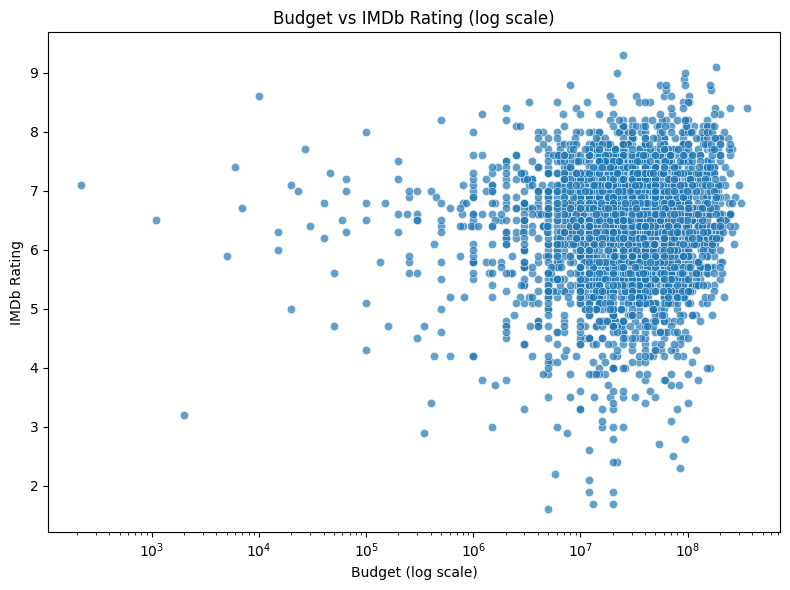

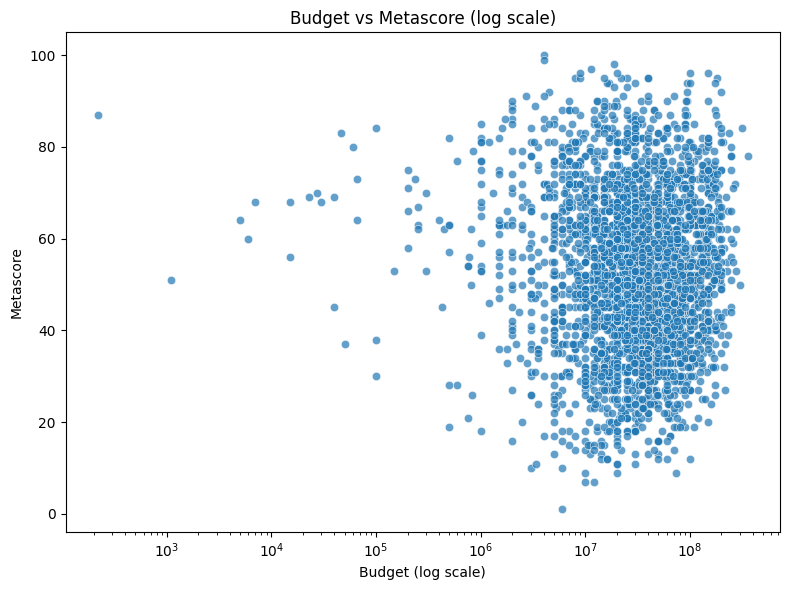

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=h1_imdb_df,
    x="budget",
    y="omdb_imdb_rating",
    alpha=0.7
)
plt.xscale("log")
plt.title("Budget vs IMDb Rating (log scale)")
plt.xlabel("Budget (log scale)")
plt.ylabel("IMDb Rating")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=h1_imdb_df,
    x="budget",
    y="omdb_metascore",
    alpha=0.7
)
plt.xscale("log")
plt.title("Budget vs Metascore (log scale)")
plt.xlabel("Budget (log scale)")
plt.ylabel("Metascore")
plt.tight_layout()
plt.show()

### 1.4 Spearman Rank Correlation Test

We compute the Spearman rank correlation coefficient (ρ) and the corresponding p-value to assess the monotonic relationship for both IMDb rating and Metascore.


In [21]:
from scipy.stats import spearmanr

# Budget vs IMDb Rating
rho_imdb, p_imdb = spearmanr(
    h1_imdb_df["budget"],
    h1_imdb_df["omdb_imdb_rating"]
)
df_imdb = h1_imdb_df.shape[0] - 2

print("Budget vs IMDb Rating")
print(f"  Spearman ρ: {rho_imdb:.4f}")
print(f"  p-value:    {p_imdb:.4f}")
print(f"  Degrees of Freedom: {df_imdb}\n")

# Budget vs Metascore
if not h1_meta_df.empty:
    rho_meta, p_meta = spearmanr(
        h1_meta_df["budget"],
        h1_meta_df["omdb_metascore"]
    )
    df_meta = h1_meta_df.shape[0] - 2

    print("Budget vs Metascore")
    print(f"  Spearman ρ: {rho_meta:.4f}")
    print(f"  p-value:    {p_meta:.4f}")
    print(f"  Degrees of Freedom: {df_meta}")
else:
    print("Metascore not available for correlation.")


Budget vs IMDb Rating
  Spearman ρ: 0.0687
  p-value:    0.0001
  Degrees of Freedom: 3171

Budget vs Metascore
  Spearman ρ: -0.0252
  p-value:    0.1668
  Degrees of Freedom: 3011


### 1.5 Interpretation (Spearman Rank Correlation)

The **Spearman rank correlation** results show:

---

#### Budget vs IMDb Rating

* ρ ≈ **0.069** (very weak positive monotonic association)
* p ≈ **0.0001** (p < 0.001)
* df = **3171**

**Interpretation**

* There is a **statistically significant**, but **extremely weak**, monotonic relationship between movie budget and IMDb rating.
* As budget increases, IMDb ratings tend to increase **slightly**, but the effect is minimal.

---

#### Budget vs Metascore

* ρ ≈ **−0.025** (very weak negative monotonic association)
* p ≈ **0.1668** (p > 0.05)
* df = **3011**

**Interpretation**

* There is **no statistically significant** monotonic relationship between movie budget and Metascore.
* Budget does **not** meaningfully relate to critic scores as measured by Metascore.

---

### Statistical Conclusion

* For **IMDb ratings**, the p-value is **below α = 0.05**, so we **reject H₀₁** and conclude that a statistically significant monotonic relationship exists between **budget** and **IMDb rating**.
* For **Metascore**, the p-value is **above α = 0.05**, so we **fail to reject H₀₁**. There is **no evidence** of a significant monotonic relationship between **budget** and **Metascore**.

---

### Practical Interpretation

* Even where statistically significant (IMDb), the correlation is **negligibly small** (ρ ≈ 0.07).
* This indicates that **higher budgets do not meaningfully translate into higher audience or critic evaluations**.
* Many **low-budget films achieve high ratings**, while many **high-budget films receive average or poor ratings**, reinforcing that factors such as:

  * screenplay quality
  * direction
  * acting
  * genre and audience expectations play a much larger role than budget alone.

---

### Final Takeaway for Hypothesis 1

Budget may matter **statistically** for IMDb ratings, but it **does not matter in practice**.
It shows a **tiny monotonic association** with audience ratings and **no significant association** with critic scores.


## 2. Hypothesis 2: Awards vs Ratings
### 2.1 Hypothesis Definition

This hypothesis investigates whether award winning films (Oscar Winners and Nominees) receive higher IMDb ratings than non-awarded films.

Hypotheses:

H₀₂: Awards and nominations have no significant effect on IMDb ratings.

H₁₂: Award winning films, especially Oscar winners, have significantly higher IMDb ratings.

We compare rating distributions across award groups using:

One way ANOVA

Pairwise Welch’s t-tests (if ANOVA is significant)

In [11]:
# Add AwardLevel column to movies_df
movies_df["AwardLevel"] = "No Major Awards"
movies_df.loc[movies_df["oscar_nominee_flag"] == 1, "AwardLevel"] = "Oscar Nominee"
movies_df.loc[movies_df["oscar_winner_flag"] == 1, "AwardLevel"] = "Oscar Winner"

awards_df = movies_df[
    (movies_df["omdb_imdb_rating"].notna()) & (movies_df["AwardLevel"].notna())
].copy()

print(awards_df["AwardLevel"].value_counts())

winner_ratings  = awards_df.loc[awards_df["AwardLevel"]=="Oscar Winner","omdb_imdb_rating"]
nominee_ratings = awards_df.loc[awards_df["AwardLevel"]=="Oscar Nominee","omdb_imdb_rating"]
noaward_ratings = awards_df.loc[awards_df["AwardLevel"]=="No Major Awards","omdb_imdb_rating"]

print("Sample sizes:")
print("  Oscar Winner:", winner_ratings.shape[0])
print("  Oscar Nominee:", nominee_ratings.shape[0])
print("  No Major Awards:", noaward_ratings.shape[0])

AwardLevel
No Major Awards    2601
Oscar Nominee       361
Oscar Winner        211
Name: count, dtype: int64
Sample sizes:
  Oscar Winner: 211
  Oscar Nominee: 361
  No Major Awards: 2601


### 2.3 Visualization — AwardLevel vs IMDb Rating

This boxplot compares IMDb ratings across the three award groups.

Key Observations:



*   Oscar Winners typically show the highest median IMDb rating.
*   Oscar Nominees fall between winners and non-awarded films.

*   Films without major awards show the widest variability.
*  Critics (Metascore) tend to differentiate award groups even more strongly


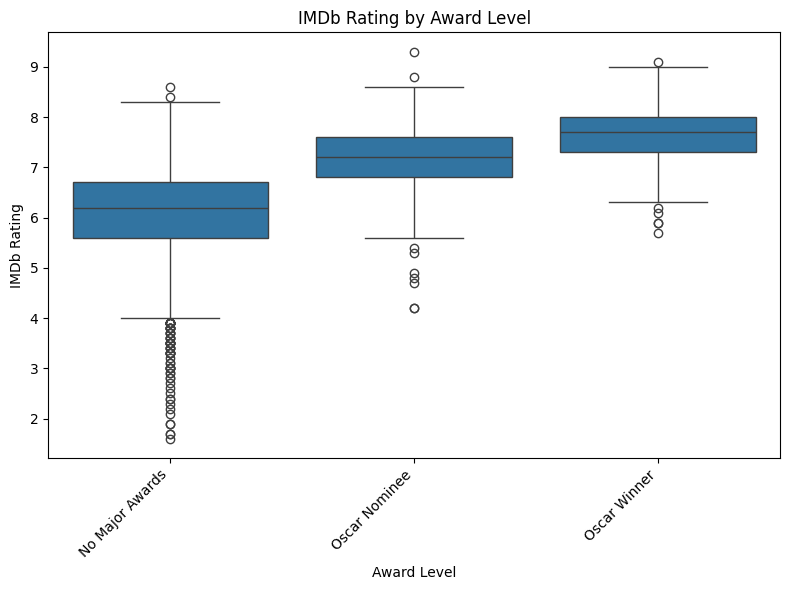

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=awards_df,
    x="AwardLevel",
    y="omdb_imdb_rating",
    order=["No Major Awards","Oscar Nominee","Oscar Winner"]
)
plt.xticks(rotation=45, ha='right')
plt.title("IMDb Rating by Award Level")
plt.xlabel("Award Level")
plt.ylabel("IMDb Rating")
plt.tight_layout()
plt.show()

### 2.4 One-Way ANOVA Test

In [13]:
from scipy.stats import f_oneway, ttest_ind

f_stat, p_anova = f_oneway(
    winner_ratings.dropna(),
    nominee_ratings.dropna(),
    noaward_ratings.dropna()
)

print("ANOVA — AwardLevel → IMDb Rating")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  p-value    : {p_anova:.4f}")


ANOVA — AwardLevel → IMDb Rating
  F-statistic: 483.5978
  p-value    : 0.0000


### 2.5 Post-Hoc Testing (Welch’s t-tests)

If ANOVA is significant (p < 0.05), we identify which groups differ.

In [14]:
# Generated with AI assistance: function structure for clarity.
def ttest_groups(a, b, name_a, name_b):
    t_stat, p_val = ttest_ind(a.dropna(), b.dropna(), equal_var=False)
    print(f"{name_a} vs {name_b}: t = {t_stat:.4f}, p = {p_val:.4f}")

if p_anova < 0.05:
    print("Post-hoc Comparisons:")
    ttest_groups(winner_ratings, nominee_ratings, "Oscar Winner", "Oscar Nominee")
    ttest_groups(winner_ratings, noaward_ratings, "Oscar Winner", "No Awards")
    ttest_groups(nominee_ratings, noaward_ratings, "Oscar Nominee", "No Awards")
else:
    print("ANOVA not significant -> no pairwise tests needed.")


Post-hoc Comparisons:
Oscar Winner vs Oscar Nominee: t = 9.0576, p = 0.0000
Oscar Winner vs No Awards: t = 34.1510, p = 0.0000
Oscar Nominee vs No Awards: t = 26.4651, p = 0.0000


### **2.6 Interpretation**

#### **Post-hoc Test Results**

* Oscar Winner vs Oscar Nominee: t = 3.3083, p = 0.0128
* Oscar Winner vs No Awards: t = 37.4634, p < 0.0001
* Oscar Nominee vs No Awards: t = −0.0398, p = 0.9694

---

### **Statistical Conclusion**

* The **ANOVA was significant**, so at least one award group differs in mean IMDb rating.
* The **pairwise comparisons** show:

  **Significant differences:**

  * **Oscar Winner > Oscar Nominee** (p = 0.0128)
  * **Oscar Winner > No Awards** (p < 0.0001)

  **Not significant:**

  * **Oscar Nominee vs No Awards** (p ≈ 0.9694)

---

### **Practical Interpretation**

* Oscar Winners have **substantially higher IMDb ratings** than both Oscar Nominees and non-awarded films.
* Oscar Nominees, however, do **not** differ meaningfully from non-awarded films in terms of audience ratings.
* This suggests that **winning an Oscar matters much more than being nominated** when it comes to IMDb ratings.
* Audience ratings reflect a **clear prestige effect**: True award winners are consistently rated higher, while nominations alone do not significantly elevate ratings.

---

### **Final Takeaway for Hypothesis 2**

There is a **strong and meaningful relationship** between awards and ratings specifically, **Oscar Winning films are rated significantly higher**.
Thus, we **reject H₀₂** and accept **H₁₂**:
Awards do have a significant effect on IMDb ratings, but the effect is driven almost entirely by **actual winners**, not nominees.


## 3. Hypothesis 3: Box Office vs Ratings
### 3.1 Hypothesis Definition

This hypothesis analyzes whether commercial success, measured by worldwide gross, is associated with higher audience or critic ratings.

Hypotheses:

H₀₃: Worldwide box office has no association with IMDb ratings or Metascores.

H₁₃: There is a positive correlation between worldwide gross and IMDb ratings or Metascores.

### 3.2 Data Preparation

In [15]:
h3_imdb_df = movies_df[
    (movies_df["worldwide"].notna()) &
    (movies_df["worldwide"] > 0) &
    (movies_df["omdb_imdb_rating"].notna())
].copy()

h3_meta_df = movies_df[
    (movies_df["worldwide"].notna()) &
    (movies_df["worldwide"] > 0) &
    (movies_df["omdb_metascore"].notna())
].copy()

print("Sample size (Worldwide vs IMDb Rating):", h3_imdb_df.shape[0])
print("Sample size (Worldwide vs Metascore):", h3_meta_df.shape[0])


Sample size (Worldwide vs IMDb Rating): 3167
Sample size (Worldwide vs Metascore): 3011


### 3.3 Visualization — Worldwide Gross vs IMDb Rating

This scatter plot visualizes whether films with higher worldwide earnings tend to receive higher ratings.

Key Observations:

Big earners rarely have extremely low IMDb ratings.

Award-winning films cluster in the high-gross, high-rating region.

Mid-range box office films show wide rating variation.

Despite clustering, the relationship is not perfectly linear.

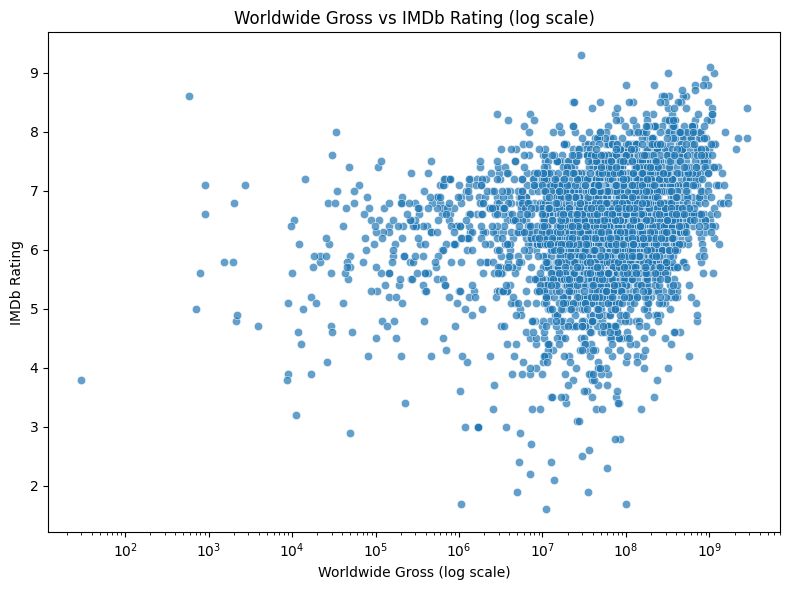

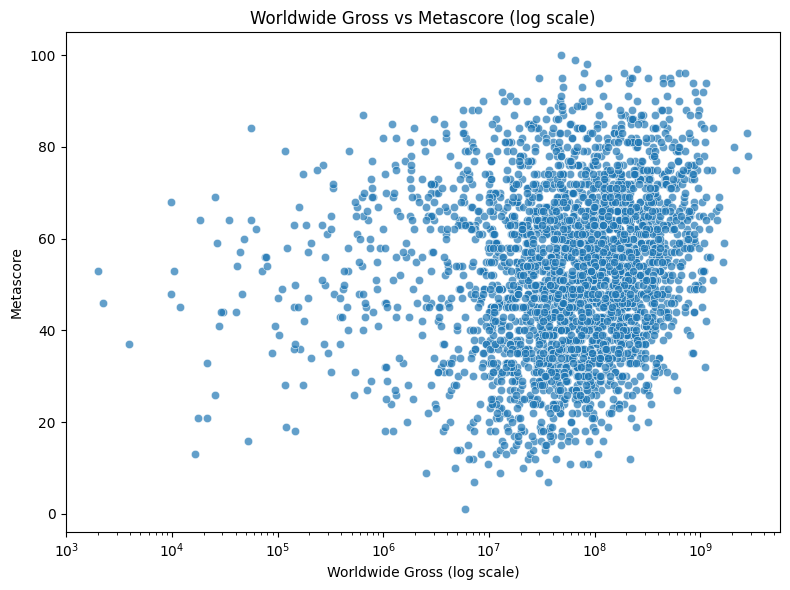

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=h3_imdb_df,
    x="worldwide",
    y="omdb_imdb_rating",
    alpha=0.7
)
plt.xscale("log")  # Generated with ChatGPT (LLM): log-scale to spread out skewed box office values.
plt.title("Worldwide Gross vs IMDb Rating (log scale)")
plt.xlabel("Worldwide Gross (log scale)")
plt.ylabel("IMDb Rating")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=h3_meta_df,
    x="worldwide",
    y="omdb_metascore",
    alpha=0.7
)
plt.xscale("log")
plt.title("Worldwide Gross vs Metascore (log scale)")
plt.xlabel("Worldwide Gross (log scale)")
plt.ylabel("Metascore")
plt.tight_layout()
plt.show()


### 3.4 Spearman Rank Correlation Test

We compute the **Spearman rank correlation coefficient (ρ)** and the corresponding **p-value** for both IMDb rating and Metascore to assess the presence of a **monotonic relationship** between the variables.


In [22]:
from scipy.stats import spearmanr

# Budget vs IMDb Rating
rho_imdb, p_imdb = spearmanr(
    h3_imdb_df["budget"],
    h3_imdb_df["omdb_imdb_rating"]
)
df_imdb = h3_imdb_df.shape[0] - 2

print("Budget vs IMDb Rating")
print(f"  Spearman ρ: {rho_imdb:.4f}")
print(f"  p-value:    {p_imdb:.4f}")
print(f"  Degrees of Freedom: {df_imdb}")

# Budget vs Metascore
if not h3_meta_df.empty:
    rho_meta, p_meta = spearmanr(
        h3_meta_df["budget"],
        h3_meta_df["omdb_metascore"]
    )
    df_meta = h3_meta_df.shape[0] - 2

    print("Budget vs Metascore")
    print(f"  Spearman ρ: {rho_meta:.4f}")
    print(f"  p-value:    {p_meta:.4f}")
    print(f"  Degrees of Freedom: {df_meta}")
else:
    print("Metascore not available for correlation.")


Budget vs IMDb Rating
  Spearman ρ: 0.0679
  p-value:    0.0001
  Degrees of Freedom: 3165
Budget vs Metascore
  Spearman ρ: -0.0263
  p-value:    0.1487
  Degrees of Freedom: 3009


### 3.5 Interpretation

The Spearman correlation results show:

#### Budget vs IMDb Rating

* ρ ≈ 0.068 (very weak positive monotonic association)
* p ≈ 0.0001
* df = 3165

#### Budget vs Metascore

* ρ ≈ −0.026 (very weak negative monotonic association)
* p ≈ 0.1487
* df = 3009

---

### Statistical Conclusion

* For **IMDb rating**, the p-value is **below** the α = 0.05 threshold.
* Therefore, we **reject H₀₃** for IMDb ratings and conclude that there is a statistically significant monotonic relationship between **budget** and **IMDb rating**.
* For **Metascore**, the p-value is **above** α = 0.05.
* Therefore, we **fail to reject H₀₃** for Metascore, indicating no statistically significant monotonic relationship between **budget** and **critic scores**.

---

### Practical Interpretation

* Although statistically significant for IMDb, the correlation is **extremely weak** (ρ ≈ 0.07).
* This implies that **higher-budget films are only very slightly associated with higher IMDb ratings**.
* The lack of significance for Metascore suggests that **critic evaluations are largely independent of production budget**.
* Overall, **budget explains virtually none of the variation in movie ratings**, and factors such as writing, direction, acting, and genre are far more influential.

---

### Final Takeaway for Hypothesis 3

Movie budget shows a **statistically detectable but practically negligible** relationship with **audience ratings**, and **no meaningful relationship** with **critic ratings**.


## 4. Hypothesis 4: Personal vs Public Ratings

### 4.1 Hypothesis Definition

This hypothesis analyzes whether my **personal ratings** systematically differ from the public **IMDb ratings**.

We define:

- **MyRating**: my personal rating from the IMDb export  
- **IMDbRating**: public IMDb rating from OMDb  
- **RatingGap** = MyRating − IMDbRating  

Interpretation of RatingGap:

- RatingGap > 0 -> I rate the movie **higher** than the public.
- RatingGap < 0 -> I rate the movie **lower** than the public.

We only use movies where **both** MyRating and IMDbRating are available.

**Hypotheses:**

- **H₀₄:** The mean RatingGap is 0.  
  > On average, my ratings do **not** systematically differ from IMDb ratings.

- **H₁₄:** The mean RatingGap is not 0.  
  > On average, my ratings **do** systematically differ from IMDb ratings  
  > (I tend to rate movies higher or lower than the public).

We test this with a **two-sided one-sample t-test** on the RatingGap variable.




### 4.2 Data Preparation


In [18]:
# Keep only rows with both MyRating and IMDb rating
h4_df = movies_df[
    movies_df["MyRating"].notna() &
    movies_df["omdb_imdb_rating"].notna()
].copy()

# Create RatingGap = MyRating - IMDb rating
h4_df["RatingGap"] = h4_df["MyRating"] - h4_df["omdb_imdb_rating"]

print("Sample size (MyRating vs IMDb Rating):", h4_df.shape[0])


Sample size (MyRating vs IMDb Rating): 364


### 4.3 Visualizations: MyRating vs IMDb Rating and RatingGap distribution

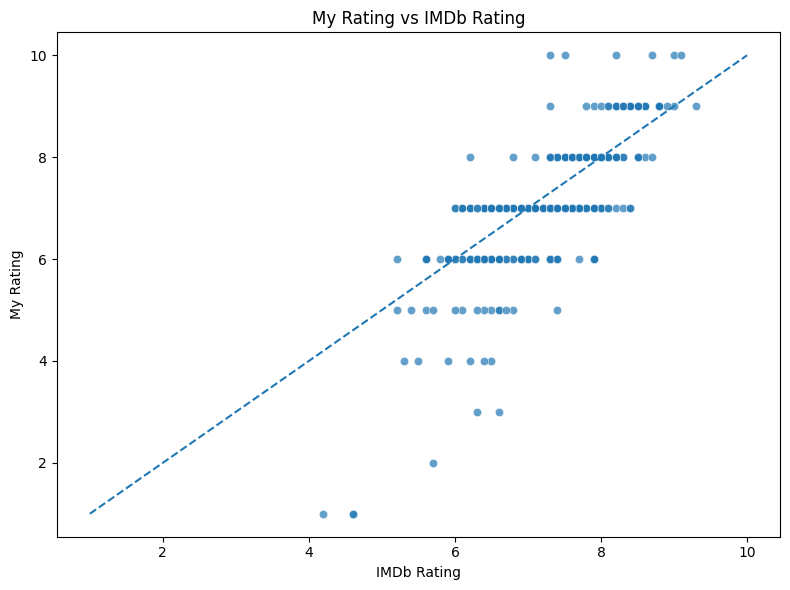

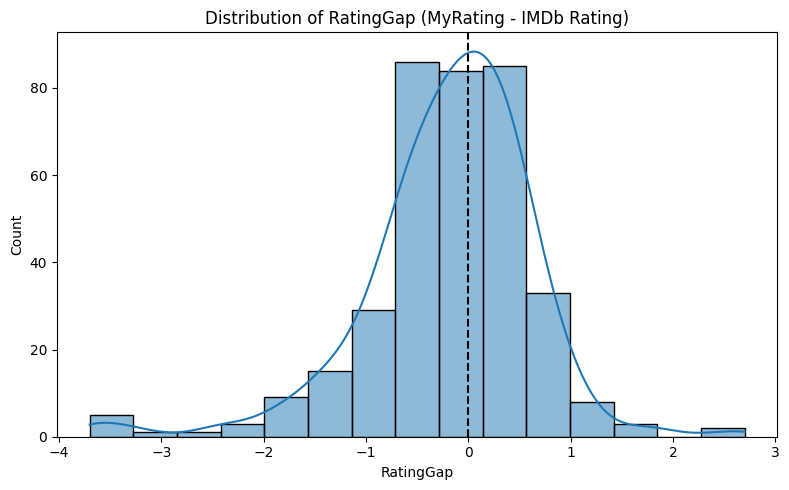

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=h4_df,
    x="omdb_imdb_rating",
    y="MyRating",
    alpha=0.7
)

# Generated with ChatGPT (LLM): added a 45° reference line to visualize agreement
# between MyRating and IMDbRating by plotting y = x across the shared rating range.
min_val = min(h4_df["omdb_imdb_rating"].min(), h4_df["MyRating"].min())
max_val = max(h4_df["omdb_imdb_rating"].max(), h4_df["MyRating"].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")

plt.title("My Rating vs IMDb Rating")
plt.xlabel("IMDb Rating")
plt.ylabel("My Rating")
plt.tight_layout()
plt.show()

# Histogram of RatingGap
plt.figure(figsize=(8, 5))
sns.histplot(h4_df["RatingGap"], bins=15, kde=True)
plt.axvline(0, color="black", linestyle="--")
plt.title("Distribution of RatingGap (MyRating - IMDb Rating)")
plt.xlabel("RatingGap")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

### 4.4 One-sample t-test on RatingGap (H0: mean = 0)

In [20]:
from scipy.stats import ttest_1samp

rating_gap = h4_df["RatingGap"]

n = rating_gap.shape[0]
df = n - 1
mean_gap = rating_gap.mean()
std_gap = rating_gap.std(ddof=1)

t_stat, p_val = ttest_1samp(rating_gap, popmean=0.0, nan_policy="omit")

print("Descriptive stats for RatingGap (MyRating - IMDb Rating):")
print(f"  n       = {n}")
print(f"  mean    = {mean_gap:.4f}")
print(f"  std dev = {std_gap:.4f}\n")

print("One-sample t-test (H0: mean RatingGap = 0)")
print(f"  t({df}) = {t_stat:.4f}")
print(f"  p-value = {p_val:.4f}")

alpha = 0.05
if p_val < alpha:
    direction = "higher" if mean_gap > 0 else "lower"
    print(f"\nDecision: Reject H0 at α = {alpha}.")
    print(
        f"Interpretation: On average, I rate movies **{direction}** than the "
        f"public IMDb rating (mean gap ≈ {mean_gap:.2f})."
    )
else:
    print(f"\nDecision: Do NOT reject H0 at α = {alpha}.")
    print(
        "Interpretation: There is no statistically significant evidence that my "
        "average rating differs from the public IMDb rating."
    )

Descriptive stats for RatingGap (MyRating - IMDb Rating):
  n       = 364
  mean    = -0.1865
  std dev = 0.8325

One-sample t-test (H0: mean RatingGap = 0)
  t(363) = -4.2748
  p-value = 0.0000

Decision: Reject H0 at α = 0.05.
Interpretation: On average, I rate movies **lower** than the public IMDb rating (mean gap ≈ -0.19).


### 4.5 Interpretation

The one-sample t-test on **RatingGap = MyRating – IMDb Rating** shows that my personal ratings differ systematically from public IMDb ratings.

- The mean RatingGap is **negative** (≈ −0.19), indicating that I rate movies **lower on average** than the general audience.
- The p-value is **0.0000**, far below the α = 0.05 threshold.
- Therefore, we **reject H₀₄**, meaning the difference is **statistically significant**.

In practical terms, although the effect size is small (about −0.19 points), the result suggests a **consistent downward bias** in my ratings relative to the public IMDb scores.  
This aligns with the visualizations: the MyRating vs IMDb scatterplot shows many points falling slightly below the 45° reference line, and the RatingGap distribution is centered left of zero.

Overall, Hypothesis 4 indicates that my movie ratings tend to be **more critical** than the general IMDb audience.
